# Numerics of Machine Learning
## Exercise Sheet No. 3 — Computation-Aware Gaussian Process Inference

---
University of Tübingen, Winter Term 2022/23
&copy; N. Bosch, J. Grosse, P. Hennig, A. Kristiadi, M. Pförtner, J. Schmidt, F. Schneider, L. Tatzel, J. Wenger, 2022 CC BY-NC-SA 3.0

PLEASE FILL OUT FOR ALL TEAM MEMBERS:
- Last name, first name, Matrikelnr.
- Last name, first name, Matrikelnr.

The homework must be submitted as a `.pdf` on ILIAS. We do not grade `.ipynb` submissions.

In [1]:
from matplotlib import pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi":200})

## Computation-Aware Gaussian Process Inference

This week we will try to get a better understanding of the computation-aware iterative Gaussian process approximation framework described in the lecture. We will again use the implementation of the IterGP framework from last time. If you installed the package last week, you can skip the first step.


**Task:** Install [IterGP](https://github.com/JonathanWenger/itergp), a package for iterative Gaussian process inference from our lab:

```sh
pip uninstall probnum
git clone https://github.com/JonathanWenger/itergp
cd itergp
pip install .
```

Should you have trouble with the installation, please open an [issue on GitHub](https://github.com/JonathanWenger/itergp/issues).

In [2]:
import numpy as np
import itergp
from probnum import backend, randprocs, linops, problems, randvars, linalg

We begin by generating a synthetic dataset from a known latent function. For this sheet you can adjust the size of the dataset to your hardware.

In [3]:
# Latent function
fun = lambda x: backend.sin(x * 2 * backend.pi)

# Generate data
rng_state = backend.random.rng_state(42)

num_data = 10
input_shape = ()
output_shape = ()

rng_state, rng_state_data = backend.random.split(rng_state, num=2)
data = itergp.datasets.SyntheticDataset(
    rng_state=rng_state,
    size=(num_data, num_data // 2),
    input_shape=input_shape,
    output_shape=output_shape,
    noise_var=0.1,
    fun=fun,
)
X = data.train.X
y = data.train.y


Next, we will define the Gaussian process prior to use and the likelihood, describing our observation model.

In [4]:
from itergp import GaussianProcess
from probnum.randprocs import kernels, mean_fns

# Model
mean_fn = mean_fns.Zero(input_shape=input_shape, output_shape=output_shape)
kernel = kernels.Matern(input_shape=input_shape, nu=1.5, lengthscale=0.15)
gp = GaussianProcess(mean_fn, kernel)

# Likelihood
sigma_sq = 0.1
noise = randvars.Normal(
    mean=backend.zeros(y.shape),
    cov=linops.Scaling(sigma_sq, shape=(num_data, num_data)),
)

We can now choose one of the iterative approximation methods defined in [`itergp.methods`](https://itergp.readthedocs.io/en/latest/api/methods.html) to compute the combined posterior.

In [5]:
from itergp import methods

# Approximation method
maxiter = 10
approx_method = methods.Cholesky(maxrank = maxiter)

In [6]:
# Combined posterior
gp_post = gp.condition_on_data(X=X, Y=y, b=noise, approx_method=approx_method)


In [7]:
gp_post(data.test.X)

<Normal with shape=(5,), dtype=float64>

**Task**: Plot the true function, the mathematical posterior and the computational and combined uncertainty of the Gaussian process approximation via IterGP after 5 iterations for the partial Cholesky and the conjugate gradient method. You can make use of our implementations of the [iterative approximation methods](https://itergp.readthedocs.io/en/latest/api/methods.html).

_Hint: The plotting function [`gp.plot`](https://itergp.readthedocs.io/en/latest/api/automod/itergp.ConditionalGaussianProcess.html#itergp.ConditionalGaussianProcess.plot) of an (approximate) Gaussian process (conditioned on data) may be useful._

In [8]:
# Prediction
Xnew = backend.linspace(-1.5, 1.5, 1000)
gp_post_true = gp.condition_on_data(X, y, b=noise, approx_method=methods.Cholesky())

In [9]:
# Approximation method parameters
pseudo_inputs = X

# Plot setup
fig, axs = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(8, 6),
    sharex=True,
    squeeze=False,
    gridspec_kw={"height_ratios": [2, 1, 2, 1]},
)
fig.patch.set_alpha(0.0)  # set figure background opacity to 0
plt.close()


def animate(i):

    for ax in axs.flatten():
        ax.cla()

    # Cholesky
    gp_post = gp.condition_on_data(
        X, y, b=noise, approx_method=methods.Cholesky(maxrank=i)
    )
    gp_post.plot(
        X=Xnew, data=(X, y), samples=0, computational_predictive=True, ax=axs[0, 0]
    )
    axs[0, 0].set(ylim=[-2.75, 2.75], ylabel="$y$", title="Cholesky")

    axs[1, 0].fill_between(
        x=Xnew,
        y1=backend.zeros_like(Xnew),
        y2=gp_post_true.var(Xnew),
        lw=0.0,
        alpha=0.4,
        color="C0",
    )
    axs[1, 0].fill_between(
        x=Xnew,
        y1=gp_post_true.var(Xnew),
        y2=gp_post.var(Xnew),
        alpha=0.4,
        color="C2",
    )
    axs[1, 0].set(xlabel="$x$", ylabel="Variance")
    axs[1, 0].set_ylim(bottom=0)

    # Conjugate Gradient
    gp_post = gp.condition_on_data(X, y, b=noise, approx_method=methods.CG(maxiter=i))
    gp_post.plot(
        X=Xnew, data=(X, y), samples=0, computational_predictive=True, ax=axs[0, 1]
    )
    axs[0, 1].set(ylim=[-2.75, 2.75], ylabel="$y$", title="CG")

    axs[1, 1].fill_between(
        x=Xnew,
        y1=backend.zeros_like(Xnew),
        y2=gp_post_true.var(Xnew),
        lw=0.0,
        alpha=0.4,
        color="C0",
    )
    axs[1, 1].fill_between(
        x=Xnew,
        y1=gp_post_true.var(Xnew),
        y2=gp_post.var(Xnew),
        alpha=0.4,
        color="C2",
    )
    axs[1, 1].set(xlabel="$x$", ylabel="Variance")
    axs[1, 1].set_ylim(bottom=0)

    # Pseudo-Input
    pseudo_input_method = methods.PseudoInput(pseudo_inputs=pseudo_inputs[0:i])
    gp_post = gp.condition_on_data(X, y, b=noise, approx_method=pseudo_input_method)
    gp_post.plot(
        X=Xnew, data=(X, y), samples=0, computational_predictive=True, ax=axs[2, 0]
    )
    axs[2, 0].set(ylabel="$y$", title="Pseudo-Input")

    data_range = X.max() - X.min()
    data_width = 0.015 * data_range
    for j in [2, 3]:
        for z in pseudo_input_method.pseudo_inputs:
            axs[j, 0].axvspan(
                xmin=z - 0.5 * data_width,
                xmax=z + 0.5 * data_width,
                color="black",
                alpha=0.2,
                zorder=-10,
                lw=0.0,
            )

    axs[3, 0].fill_between(
        x=Xnew,
        y1=backend.zeros_like(Xnew),
        y2=gp_post_true.var(Xnew),
        lw=0.0,
        alpha=0.4,
        color="C0",
    )
    axs[3, 0].fill_between(
        x=Xnew,
        y1=gp_post_true.var(Xnew),
        y2=gp_post.var(Xnew),
        lw=0.25,
        alpha=0.4,
        color="C2",
    )
    axs[3, 0].set(xlabel="$x$", ylabel="Variance")
    axs[3, 0].set_ylim(bottom=0)

    # Projected Bayes Regressor
    gp_post = gp.condition_on_data(X, y, b=noise, approx_method=methods.PBR(maxiter=i))
    gp_post.plot(
        X=Xnew, data=(X, y), samples=0, computational_predictive=True, ax=axs[2, 1]
    )
    axs[2, 1].set(ylim=[-2.75, 2.75], ylabel="$y$", title="PBR")

    axs[3, 1].fill_between(
        x=Xnew,
        y1=backend.zeros_like(Xnew),
        y2=gp_post_true.var(Xnew),
        lw=0.0,
        alpha=0.4,
        color="C0",
    )
    axs[3, 1].fill_between(
        x=Xnew,
        y1=gp_post_true.var(Xnew),
        y2=gp_post.var(Xnew),
        alpha=0.4,
        color="C2",
    )
    axs[3, 1].set(xlabel="$x$", ylabel="Variance")
    axs[3, 1].set_ylim(bottom=0)

    # True function
    for m in range(axs.shape[0]):
        if m % 2 == 0:
            for j in range(axs.shape[1]):
                axs[m, j].plot(
                    Xnew,
                    fun(Xnew),
                    color="gray",
                    zorder=-1,
                    label="True function"
                )


    # True GP Posterior
    for m in range(axs.shape[0]):
        if m % 2 == 0:
            for j in range(axs.shape[1]):
                axs[m, j].plot(
                    Xnew,
                    gp_post_true.mean(Xnew),
                    color="black",
                    zorder=-1,
                    label="True GP mean",
                )
                axs[m, j].plot(
                    Xnew,
                    gp_post_true.mean(Xnew) + 2 * gp_post_true.std(Xnew),
                    linestyle="--",
                    color="black",
                    zorder=-1,
                )
                axs[m, j].plot(
                    Xnew,
                    gp_post_true.mean(Xnew) - 2 * gp_post_true.std(Xnew),
                    linestyle="--",
                    color="black",
                    zorder=-1,
                )

    fig.suptitle(f"Iteration {i}")
    fig.tight_layout()


from IPython.display import HTML
from matplotlib import animation

# Create animation
anim = animation.FuncAnimation(
    fig, func=animate, frames=num_data + 1, interval=1250, repeat_delay=4000, blit=False
)

# Create interactive plot
HTML(anim.to_jshtml())

/tmp/ipykernel_571716/1983721825.py:179: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


**Questions:** 
1. Which two functions lie with high probability within the computational, and of the combined uncertainty, respectively?

    _Answer:_ The mathematical posterior is highly likely to lie within the computational uncertainty, while the true function is highly likely to lie within the combined uncertainty.

2. Does the combined uncertainty always contain the mathematical uncertainty? If yes, why? If no, why not?

    _Answer:_ The combined covariance is a sum of the mathematical and computational covariance. The same generally does not hold true for the standard deviation!

3. Which method converges fastest to the mathematical posterior? Does that come with drawbacks?
   
   _Answer:_ CG converges fastest to the mathematical posterior mean, but potentiall at the expense of reducing uncertainty compared to some other methods.

## Implementing a Policy

We saw in the lecture that the choice of action in each iteration, given by the policy, strongly influences the convergence to the mathematical posterior. In this second part, we will implement a variant of the PseudoInput policy, which at each iteration returns an action $s_i = \text{Policy}()$ given by
$$
s_i = k(X, x_i)
$$
where $X \in \mathbb{R}^{n \times d}$ is the entire training dataset and $x_i$ the datapoint selected at iteration $i$.

We begin by initializing the quantities needed for the probabilistic linear solver at the heart of IterGP.

In [10]:
from itergp.linops import KernelMatrix

# Linear system to solve
Khat = KernelMatrix(kernel=kernel + kernels.WhiteNoise(input_shape=input_shape, sigma_sq=sigma_sq), x0=X)
problem = problems.LinearSystem(Khat, y)

# Prior for probabilistic linear solver
P = linops.Zero(shape=(X.shape[0], X.shape[0]))
Pinv = linops.Zero(shape=(X.shape[0], X.shape[0]))
linsys_prior = linalg.solvers.beliefs.LinearSystemBelief(
    x=randvars.Normal(mean=Pinv @ problem.b, cov=Khat.inv()),
    Ainv=Pinv,
    A=P,
)

# Initial solver state for experimentation
solver_state = linalg.solvers.LinearSolverState(problem=problem, prior=linsys_prior)


The solver's internal state is tracked in `solver_state` which contains quantities like the current `step` and the `problem` definition.

In [11]:
print(solver_state.step)
solver_state.next_step()
solver_state.next_step()
print(solver_state.step)

0
2


**Task:** Complete the implementation of the "PseudoInput" policy below. When called it should return the kernel function centered at the datapoint $x_i$ as defined above.

In [12]:
from typing import Optional

from probnum import backend
from probnum.backend.random import RNGState
from probnum.linalg.solvers import policies


class CustomPseudoInputPolicy(policies.LinearSolverPolicy):
    """Custom PseudoInputPolicy.

    Parameters
    ----------
    X 
        Training data.
    kernel
        Prior covariance function.
    """
    def __init__(self, X : backend.Array, kernel : randprocs.kernels.Kernel) -> None:
        self.X = X
        self.kernel = kernel
        super().__init__()

    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        """Return an action for a given solver state.

        Parameters
        ----------
        solver_state
            Current state of the linear solver.
        rng
            Random number generator.

        Returns
        -------
        action
            Next action to take.
        """
        return self.kernel.matrix(self.X, self.X[solver_state.step])


**Task:** Test out your policy by calling it and seeing what actions it returns. If your implementation is correct, all points should lie on the plot of the kernel function centered at $x_i$.

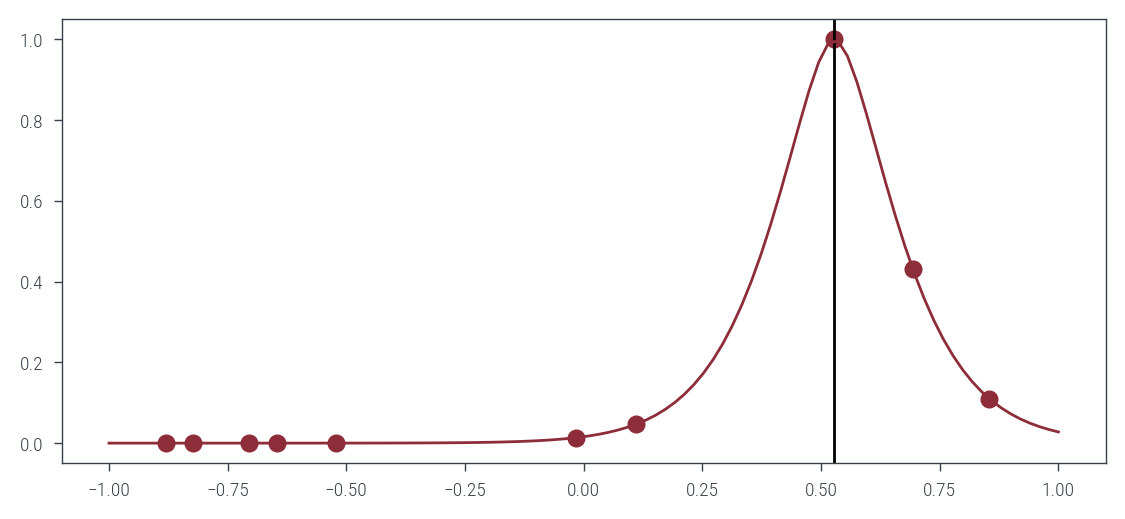

In [16]:
# Create policy
my_policy = CustomPseudoInputPolicy(X=X, kernel=kernel)

# Generate action from policy
action = my_policy(solver_state)

# Plot
plt.axvline(X[solver_state.step], color="black")
plt.scatter(X, action)
plt.plot(
    backend.linspace(-1, 1, 100),
    kernel(backend.linspace(-1, 1, 100), X[solver_state.step]),
)
plt.show()


**Task:** Compile your custom probabilistic linear solver by passing the custom policy to the super class constructor.

In [17]:
"""Custom probabilistic linear solver."""
import probnum
from probnum.linalg.solvers import ProbabilisticLinearSolver, information_ops
from itergp.methods import belief_updates, policies, stopping_criteria


class CustomSolver(ProbabilisticLinearSolver):
    r"""Custom probabilistic linear solver.

    Parameters
    ----------
    atol
        Absolute tolerance.
    rtol
        Relative tolerance.
    maxiter
        Maximum number of iterations.
    """

    def __init__(
        self,
        atol: float = 1e-6,
        rtol: float = 1e-6,
        maxiter: int = None,
    ):
        super().__init__(
            policy=CustomPseudoInputPolicy(X=X, kernel=kernel), # TODO
            information_op=information_ops.ProjectedResidualInformationOp(),
            belief_update=belief_updates.ProjectedResidualBeliefUpdate(),
            stopping_criterion=stopping_criteria.MaxIterationsStoppingCriterion(
                maxiter=maxiter, problem_size_factor=1
            )
            | probnum.linalg.solvers.stopping_criteria.ResidualNormStoppingCriterion(
                atol=atol, rtol=rtol
            ),
        )


In [18]:
# Approximate GP posterior
gp_post = gp.condition_on_data(
    X=X, Y=y, b=noise, approx_method=CustomSolver(maxiter=8)
)


**Task:** Plot the (approximate) GP posterior including the combined and computational uncertainty.

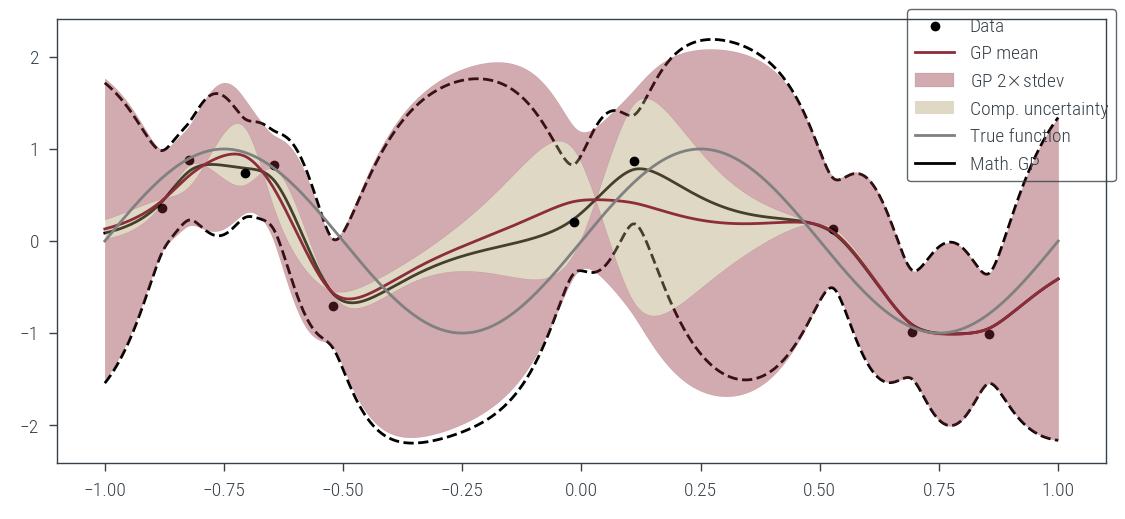

In [19]:
fig, ax = plt.subplots()
Xnew = backend.linspace(-1, 1, 1000)
gp_post.plot(Xnew, data=(X, y), computational_predictive=True, ax=ax)
ax.plot(Xnew, fun(Xnew), color="gray", label="True function")
ax.plot(
    Xnew,
    gp_post_true.mean(Xnew),
    color="black",
    zorder=-1,
    label="Math. GP",
)
ax.plot(
    Xnew,
    gp_post_true.mean(Xnew) + 2 * gp_post_true.std(Xnew),
    linestyle="--",
    color="black",
    zorder=-1,
)
ax.plot(
    Xnew,
    gp_post_true.mean(Xnew) - 2 * gp_post_true.std(Xnew),
    linestyle="--",
    color="black",
    zorder=-1,
)
fig.legend()
plt.show()


**Question:** How does your custom policy compare to the partial Cholesky? How would you change it to improve it compared to the partial Cholesky?

_Answer:_ It is very similar, since it also primarily reduces uncertainty near the data points. For improvements, place the kernel functions strategically placed throughout the input space to cover the dataset.